# A4.4 Convolutional Neural Networks

*Sarah Houlton*


The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

In [1]:
import numpy as np
import torch
import time
import copy
import sys

class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers

        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
        # A4.3 version moved following statement left one indent level
        
        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

            
        #    You fill in the rest of the train function, following lecture notes example.
        #    .
        #    .
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=learning_rate)
        
        loss_F = torch.nn.CrossEntropyLoss()
        
        for epoch in range(n_epochs):
            
            optimizer.zero_grad()
    
            Yt = self.nnet(X)
    
            error = loss_F(Yt, T)
            
            self.error_trace.append(error)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch} error {error:.5f}')
        
            error.backward()
    
            optimizer.step()
            
        
        self.training_time = (time.time() - start_time)
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [2]:
import matplotlib.pyplot as plt

In [3]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [4]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   kernels_size_and_stride=[[5, 2]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 0 error 0.71843
Epoch 5 error 0.53741
Epoch 10 error 0.46014
Epoch 15 error 0.38249
Epoch 20 error 0.31374
Epoch 25 error 0.25752
Epoch 30 error 0.19796
Epoch 35 error 0.15015
Epoch 40 error 0.11265
Epoch 45 error 0.09170


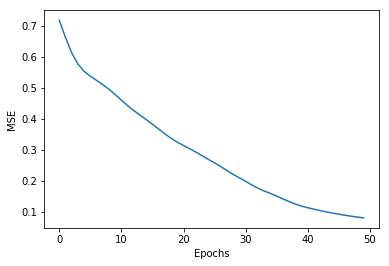

In [5]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [6]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 2.865 seconds.


Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [7]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

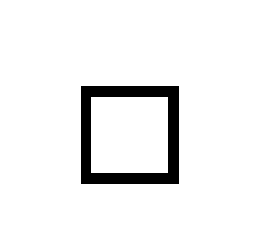

In [8]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

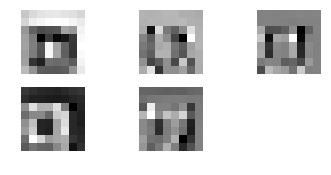

In [9]:
show_layer_output(nnet, X_sample, 0);

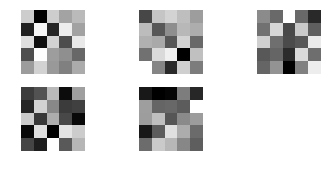

In [10]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [37]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

In [50]:
Xtest = test_set[0].reshape(-1, 1, 28, 28)
Ttest = test_set[1].reshape(-1, 1)
Xtest.shape, Ttest.shape

((10000, 1, 28, 28), (10000, 1))

In [51]:
Ttrain = Ttrain.reshape(-1)
Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtrain.shape, Ttrain.shape

((50000, 1, 28, 28), (50000,))

In [52]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

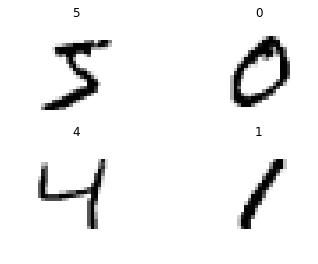

In [53]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

36% Correct I started out with the same parameters from above so that I could adjust the parameters one at a time and see how they helped or hurt. 

In [54]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], # , 5],
                                   kernels_size_and_stride=[[5, 2]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Epoch 0 error 2.45850
Epoch 5 error 1.98915
Epoch 10 error 1.90203
Epoch 15 error 1.83996
Epoch 20 error 1.78474
Epoch 25 error 1.73512
Epoch 30 error 1.69006
Epoch 35 error 1.64925
Epoch 40 error 1.61047
Epoch 45 error 1.57405


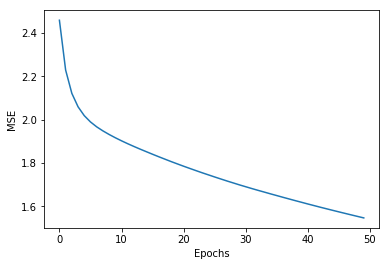

In [55]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [56]:
Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

  Correctly identified 3630 out of 10000 samples, or 36.30 percent.
  Training took 234.088 seconds.


~35% Correct For this test, I changed a few different things, but the main thing I was interested in seeing was if reducing the number of units in convolutional layers would help the accuracy. It actually decreased the accuracy so I increased it in future iterations.

In [58]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[1], # , 5],
                                   kernels_size_and_stride=[[7, 2]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.38334
Epoch 5 error 2.17016
Epoch 10 error 2.03332
Epoch 15 error 1.95256
Epoch 20 error 1.88897
Epoch 25 error 1.83288
Epoch 30 error 1.78294
Epoch 35 error 1.73831
Epoch 40 error 1.69831
Epoch 45 error 1.66211
  Correctly identified 3499 out of 10000 samples, or 34.99 percent.
  Training took 113.310 seconds.


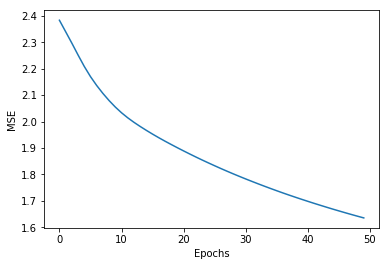

In [59]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

79% Correct For this test, I increased the kernel size and stride, as well as the n_units_in_fc_hidden_layers. This made the accuracy jump up quite a bit, so I continued increasing these in future tests. 

In [60]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[11, 4]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[5], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.32463
Epoch 5 error 1.81841
Epoch 10 error 1.62675
Epoch 15 error 1.48559
Epoch 20 error 1.35727
Epoch 25 error 1.23881
Epoch 30 error 1.13048
Epoch 35 error 1.03295
Epoch 40 error 0.94630
Epoch 45 error 0.86905
  Correctly identified 7926 out of 10000 samples, or 79.26 percent.
  Training took 152.523 seconds.


81% Correct For this iteration, I increased the kernel size and stride again without increasing n_units_in_fc_hidden_layers to try and pinpoint what factor was helping the accuracy most.

In [61]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[15, 3]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[5], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.31929
Epoch 5 error 1.73076
Epoch 10 error 1.56437
Epoch 15 error 1.43132
Epoch 20 error 1.30740
Epoch 25 error 1.19192
Epoch 30 error 1.08627
Epoch 35 error 0.99040
Epoch 40 error 0.90527
Epoch 45 error 0.83098
  Correctly identified 8131 out of 10000 samples, or 81.31 percent.
  Training took 197.124 seconds.


87% Correct To test the other factor from above, I reset the kernel size and stride and increased n_units_in_fc_hidden_layers. This improved the performance again, which led me to believe the kernel size had less of an impact.

In [62]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[10, 5]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[7], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.31192
Epoch 5 error 1.79940
Epoch 10 error 1.55355
Epoch 15 error 1.37729
Epoch 20 error 1.23184
Epoch 25 error 1.10562
Epoch 30 error 0.99401
Epoch 35 error 0.89383
Epoch 40 error 0.80247
Epoch 45 error 0.72100
  Correctly identified 8747 out of 10000 samples, or 87.47 percent.
  Training took 97.243 seconds.


87% Correct For this test, I took the best performing result so far and trained it for more epochs, expecting this to improve the accuracy. Contrary to what I expected, though, the accuracy dropped slightly over more epochs.

In [63]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[10, 5]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[5], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 75, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.38195
Epoch 5 error 1.90178
Epoch 10 error 1.71293
Epoch 15 error 1.57487
Epoch 20 error 1.45517
Epoch 25 error 1.34256
Epoch 30 error 1.23906
Epoch 35 error 1.14308
Epoch 40 error 1.05427
Epoch 45 error 0.97297
Epoch 50 error 0.89964
Epoch 55 error 0.83345
Epoch 60 error 0.77375
Epoch 65 error 0.72114
Epoch 70 error 0.67446
  Correctly identified 8700 out of 10000 samples, or 87.00 percent.
  Training took 141.166 seconds.


92% Correct For this test, I increased n_units_in_fc_hidden_layers with 75 epochs to see if it would improve the accuracy of the best performing set. This led to the first result scoring above 90%.

In [64]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[10, 5]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[10], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 75, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.31054
Epoch 5 error 1.66800
Epoch 10 error 1.34645
Epoch 15 error 1.11985
Epoch 20 error 0.93637
Epoch 25 error 0.78951
Epoch 30 error 0.67502
Epoch 35 error 0.58637
Epoch 40 error 0.51848
Epoch 45 error 0.46644
Epoch 50 error 0.42581
Epoch 55 error 0.39253
Epoch 60 error 0.36466
Epoch 65 error 0.34127
Epoch 70 error 0.32127
  Correctly identified 9208 out of 10000 samples, or 92.08 percent.
  Training took 150.821 seconds.


86% Correct For the next few tests, I decreased the epochs back to 50 ton cut down on running time. I played around with the number of units in convolutional layers to see if they would have a huge effect as I hadn't changed it much yet.

In [65]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[8], # , 5],
                                   kernels_size_and_stride=[[10, 5]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[7], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.34421
Epoch 5 error 1.84632
Epoch 10 error 1.56930
Epoch 15 error 1.36958
Epoch 20 error 1.20184
Epoch 25 error 1.05927
Epoch 30 error 0.94110
Epoch 35 error 0.84398
Epoch 40 error 0.76371
Epoch 45 error 0.69724
  Correctly identified 8676 out of 10000 samples, or 86.76 percent.
  Training took 92.853 seconds.


88% Correct For this iteration, I once again increased number of units in convolutional layers, as well as the kernel size and stride, since I knew the size and stride could increase the score, and I wanted to see if the number of units in convolutional layers would increase the score as well.

In [66]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[13], # , 5],
                                   kernels_size_and_stride=[[12, 7]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[7], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 50, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.33854
Epoch 5 error 1.77234
Epoch 10 error 1.52601
Epoch 15 error 1.34619
Epoch 20 error 1.18659
Epoch 25 error 1.04572
Epoch 30 error 0.92367
Epoch 35 error 0.81802
Epoch 40 error 0.72694
Epoch 45 error 0.64783
  Correctly identified 8876 out of 10000 samples, or 88.76 percent.
  Training took 99.333 seconds.


93% Correct For my final test, I took what I learned from the previous tests, used the best performing parameters, and increased the n_units_in_fc_hidden_layers because I knew that had increased the accuracy previously. This led to the absolute best score of the iterations I tried.

In [67]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[10], # , 5],
                                   kernels_size_and_stride=[[10, 5]], # , [4, 1]],
                                   n_units_in_fc_hidden_layers=[15], # 10, 10],
                                   classes= [0,1,2,3,4,5,6,7,8,9],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 75, learning_rate=0.01)

Yclasses, Y = nnet.use(Xtest)

n_correct = np.sum(Ttest == Yclasses)
print(f'  Correctly identified {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')
print(f'  Training took {nnet.training_time:.3f} seconds.')

Epoch 0 error 2.29052
Epoch 5 error 1.49485
Epoch 10 error 1.09767
Epoch 15 error 0.84495
Epoch 20 error 0.67293
Epoch 25 error 0.55637
Epoch 30 error 0.47628
Epoch 35 error 0.41978
Epoch 40 error 0.37763
Epoch 45 error 0.34465
Epoch 50 error 0.31804
Epoch 55 error 0.29555
Epoch 60 error 0.27619
Epoch 65 error 0.25933
Epoch 70 error 0.24447
  Correctly identified 9336 out of 10000 samples, or 93.36 percent.
  Training took 149.028 seconds.


**Required:** Try different numbers of layers and units, kernel sizes and strides, and learning rates and epochs to get greater than 90% test images correctly classified.  Your grade will only depend on you showing various results, not on achieving this accuracy.

# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [68]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Houlton-A1.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(